In [39]:
import numpy as np
import pandas as pd
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, precision_recall_curve,f1_score, roc_curve, auc
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
from sklearn.preprocessing import Binarizer
from sklearn.metrics import roc_auc_score

In [5]:
df_card = pd.read_csv('train_project.csv')
df_card.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,138482.0,-8.367621,7.402969,-5.114191,-2.966792,-0.985904,-1.660018,0.397816,1.008250,5.290976,...,-0.557927,0.349087,0.301734,0.662330,1.145939,-0.012273,1.513736,0.669504,0.69,0
1,146847.0,-1.290662,0.764452,-0.169233,-1.688528,1.984718,-0.717210,1.667635,-0.228295,-0.959071,...,0.138615,0.390374,-0.678774,0.292254,1.425865,0.265341,0.051405,0.103879,55.47,0
2,71909.0,-0.606860,0.233923,2.633361,-0.155762,-0.328850,-0.070593,0.173023,0.113394,0.680147,...,0.007393,0.265045,-0.040615,0.406088,-0.498823,0.121851,-0.046840,-0.087259,11.50,0


In [10]:
label = np.array(df_card['Class'][1:])
features = np.array(df_card.drop('Class', axis=1)[1:])

In [11]:
print(features)

[[ 1.46847000e+05 -1.29066221e+00  7.64452146e-01 ...  5.14047967e-02
   1.03879444e-01  5.54700000e+01]
 [ 7.19090000e+04 -6.06860210e-01  2.33923221e-01 ... -4.68399360e-02
  -8.72585848e-02  1.15000000e+01]
 [ 1.99000000e+04  1.37416815e+00 -3.30389107e-01 ... -3.55458200e-03
   1.30239577e-02  1.00000000e+01]
 ...
 [ 1.63864000e+05  8.27820460e-01 -2.64934391e+00 ... -2.58164373e-01
   3.78680758e-02  7.48040000e+02]
 [ 1.22571000e+05 -1.52390327e+00 -6.28705968e+00 ... -3.28557316e-01
   2.29934665e-01  1.77150000e+03]
 [ 4.34400000e+04 -1.60856031e+00  1.32745555e-01 ...  1.75060233e-01
   9.20394197e-02  1.91800000e+02]]


In [9]:
print(label)

[0 0 0 ... 0 0 0]


In [33]:
def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    
    print('confusion matrix\n', confusion)
    print('accuracy : {0:.4f}, precision : {1:.4f}, recall : {2:.4f}'.format(accuracy, precision, recall))

In [16]:
x_train, x_test, y_train, y_test = train_test_split(features, label, test_size=0.2, random_state=11)

In [17]:
lr_clf = LogisticRegression()
lr_clf.fit(x_train, y_train)
pred = lr_clf.predict(x_test)
get_clf_eval(y_test, pred)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [18]:
pred_proba_class1 = lr_clf.predict_proba(x_test)[:, 1]

precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1)
print('Shape Of Threshold List:', thresholds.shape)

thr_index = np.arange(0, thresholds.shape[0], 15)
print('Sample Threshold Index:', thr_index)
print('Sample Threshold Value', np.round(thresholds[thr_index], 2))

print('Sample Threshold Precision: ', np.round(precisions[thr_index], 3))
print('Sample Threshold Recall:', np.round(recalls[thr_index], 3))

Shape Of Threshold List: (33140,)
Sample Threshold Index: [    0    15    30 ... 33105 33120 33135]
Sample Threshold Value [0.   0.   0.   ... 0.99 1.   1.  ]
Sample Threshold Precision:  [0.002 0.002 0.002 ... 0.806 0.667 1.   ]
Sample Threshold Recall: [1.    0.983 0.983 ... 0.483 0.233 0.1  ]


In [19]:
def precision_recall_cureve_plot(y_test, pred_proba_c1):
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    plt.figure(figsize=(8, 6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary],  linestyle='--',
            label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    plt.xlabel('Treshold value')
    plt.ylabel('Precision and Recall value')
    plt.show()

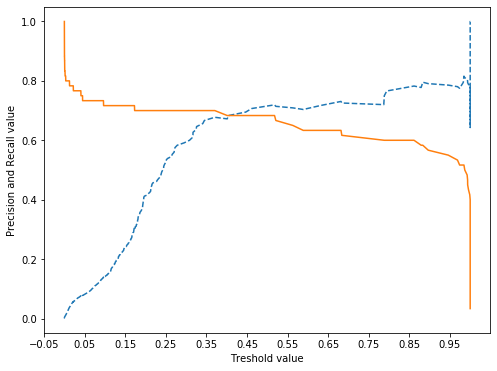

In [20]:
precision_recall_cureve_plot(y_test, lr_clf.predict_proba(x_test)[:, 1])

In [23]:
lr_clf = LogisticRegression()
knn_clf = KNeighborsClassifier(n_neighbors=8)

vo_clf = VotingClassifier(estimators=[('LR', lr_clf), ('KNN', knn_clf)], voting='soft')

x_train, x_test, y_train, y_test = train_test_split(features, label, test_size=0.2, random_state=11)

In [24]:
vo_clf.fit(x_train, y_train)
pred = vo_clf.predict(x_test)

print('Votring Classifier Accuracy: {0:.4f}'.
      format(accuracy_score(y_test, pred)))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Votring Classifier Accuracy: 0.9987


In [47]:
params = {
    'max_depth' : [6, 8, 10, 12], 
    'min_samples_leaf' : [8, 12, 18 ],
    'min_samples_split' : [8, 16, 20]
}

rf_clf = RandomForestClassifier(random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf , param_grid=params , cv=2, n_jobs=-1 )
#n_jobs = -1 means use all maximum resource (thread...)
grid_cv.fit(x_train , y_train)#learning all parms -> this case 36case = 1 X 4 X 3 X 3

print('Optimal Hyper Parameter')
print(grid_cv.best_params_)#print best performance Parameters
print('Max Accuracy: {0:.4f}'.format(grid_cv.best_score_))#print best performance score

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Optimal Hyper Parameter
{'max_depth': 8, 'min_samples_leaf': 8, 'min_samples_split': 8}
Max Accuracy: 0.9994


In [46]:
get_clf_eval(y_test, pred)

confusion matrix
 [[39811     2]
 [   18    42]]
accuracy : 0.9995, precision : 0.9545, recall : 0.7000


In [48]:
rf_clf = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=8, min_samples_leaf=8, min_samples_split=8)
pred = rf_clf.fit(x_test, y_test)
pred = rf_clf.predict(x_test)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [49]:
get_clf_eval(y_test, pred)

confusion matrix
 [[39808     5]
 [   18    42]]
accuracy : 0.9994, precision : 0.8936, recall : 0.7000


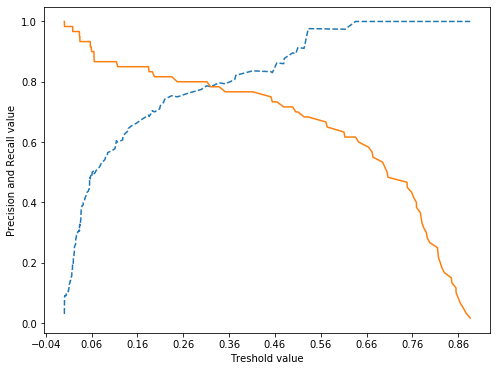

In [50]:
precision_recall_cureve_plot(y_test, rf_clf.predict_proba(x_test)[:, 1])

In [51]:
rf_clf = RandomForestClassifier(random_state=0, n_jobs=-1)

In [53]:
pred = rf_clf.fit(x_test, y_test)
pred = rf_clf.predict(x_test)
get_clf_eval(y_test, pred)

confusion matrix
 [[39813     0]
 [    6    54]]
accuracy : 0.9998, precision : 1.0000, recall : 0.9000


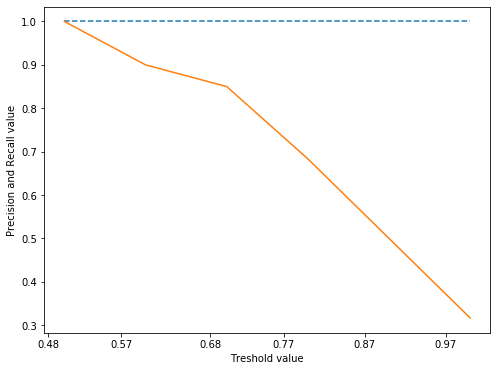

In [54]:
precision_recall_cureve_plot(y_test, rf_clf.predict_proba(x_test)[:, 1])

In [70]:
roc_score = roc_auc_score(y_test, pred)

print('ROC AUC 값: {}'.format(roc_score))

ValueError: Found input variables with inconsistent numbers of samples: [39873, 85443]

confusion matrix
 [[85289     6]
 [   70    78]]
accuracy : 0.9991, precision : 0.9286, recall : 0.5270
AUC: Area Under Curve: 0.9023698356894909


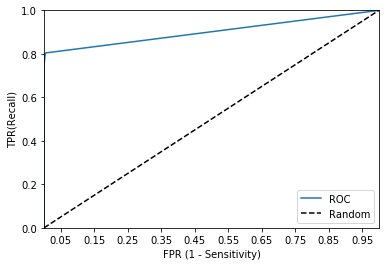

In [69]:
df_test = pd.read_csv('realTestData.csv')

df_y_test = df_test['Class']
df_x_test = df_test.drop('Class', axis = 1)

pred = rf_clf.predict(df_x_test)
get_clf_eval(df_y_test, pred)

roc_curve_plot(df_y_test, rf_clf.predict_proba(df_x_test)[:,1])

print("AUC: Area Under Curve: {}".format(roc_auc_score(df_y_test, vo_clf.predict_proba(df_x_test)[:,1])))

In [59]:
def roc_curve_plot(y_test, pred_proba_c1):
    fprs, tprs, thresholds = roc_curve(y_test, pred_proba_c1)
    
    plt.plot(fprs, tprs, label='ROC')
    plt.plot([0, 1], [0,1 ], 'k--', label='Random')
    
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel('FPR (1 - Sensitivity)')
    plt.ylabel('TPR(Recall)')
    plt.legend()
    plt.show

In [63]:
def drop_features(df):
    df.drop('Time', axis = 1, inplace = True)

In [64]:
def tranform_feature(df):
    drop_features(df)